In [12]:
import numpy as np 
import pandas as pd 
import pickle    
import matplotlib
import matplotlib.pyplot as plt
color_map = plt.cm.winter
from matplotlib.patches import RegularPolygon
import math
from PIL import Image
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors
from hockey_rink import NHLRink

In [2]:
#NHL Data from 2007 to 2020
data07_20 = pd.read_csv('shots_2007-2020.csv')

In [3]:
#clean team labels 
data07_20= data07_20.replace({'T.B':'TBL', 'L.A':'LAK', 'N.J':'NJD', 'S.J':'SJS'})

In [4]:
#NHL Data from 2021 Season , no cleaning needed 
data21 = pd.read_csv('shots_2021.csv')

In [5]:
#append data sets 
data07_21 = data07_20.append(data21, ignore_index=True)

In [6]:
#Explore the data 
Sorted = data07_21.sort_values(by='season')
Sorted.head()
Sorted.columns

Index(['shotID', 'homeTeamCode', 'awayTeamCode', 'season', 'isPlayoffGame',
       'game_id', 'homeTeamWon', 'id', 'time', 'timeUntilNextEvent',
       ...
       'xFroze', 'xRebound', 'xPlayContinuedInZone',
       'xPlayContinuedOutsideZone', 'xPlayStopped', 'xShotWasOnGoal',
       'isHomeTeam', 'shotWasOnGoal', 'teamCode', 'arenaAdjustedXCordABS'],
      dtype='object', length=124)

In [7]:
#truncating data, keep values of interest for future heatmaps 
trunc = Sorted[['awayTeamCode','homeTeamCode','team', 'event','xCordAdjusted', 'yCordAdjusted', 'season']].copy()
trunc.head()

,awayTeamCode,homeTeamCode,team,event,xCordAdjusted,yCordAdjusted,season
304307,BOS,ARI,AWAY,MISS,37,-29,2007
371243,BOS,TOR,HOME,MISS,41,13,2007
371242,BOS,TOR,HOME,MISS,66,-6,2007
371241,BOS,TOR,AWAY,GOAL,37,3,2007
371240,BOS,TOR,AWAY,MISS,77,11,2007


In [8]:
#Goals Only 
awayTemp = (trunc[(trunc['team'] == 'AWAY') & (trunc['event'] == 'GOAL')])
homeTemp = (trunc[(trunc['team'] == 'HOME') & (trunc['event'] == 'GOAL')])

#for later visualizations, remove home and away, only goals captured
aRawTemp = (Sorted[(Sorted['team'] == 'AWAY') & (Sorted['event'] == 'GOAL')])
aRaw = aRawTemp[['awayTeamCode','team', 'event','xCord', 'yCord', 'season']]
aRaw = aRaw.rename( columns={'awayTeamCode':'teamCode', 'event':'shotType','xCord':'x', 'yCord':'y', 'season':'season'})

hRawTemp = (Sorted[(Sorted['team'] == 'HOME') & (Sorted['event'] == 'GOAL')])
hRaw = hRawTemp[['homeTeamCode','team', 'event','xCord', 'yCord', 'season']]
hRaw = hRaw.rename( columns={'homeTeamCode':'teamCode', 'event':'shotType','xCord':'x', 'yCord':'y', 'season':'season'})

#for basic heatmaps with adjusted coordinates used for distance 
away = awayTemp[['awayTeamCode','team', 'event','xCordAdjusted', 'yCordAdjusted', 'season']]
home = homeTemp[['homeTeamCode','team', 'event','xCordAdjusted', 'yCordAdjusted', 'season']]

noAdjGoalDf = pd.concat([hRaw, aRaw], ignore_index=True)

rinkVisDf = noAdjGoalDf[['teamCode','x','y','season']]
print(rinkVisDf)

       teamCode   x   y  season
0           TOR -71  -3    2007
1           TOR -75  11    2007
2           TOR -73   1    2007
3           TOR -73   7    2007
4           MTL  82   3    2007
...         ...  ..  ..     ...
104792      CHI  71  -8    2021
104793      CHI -51  29    2021
104794      WSH -53 -18    2021
104795      CHI  80  10    2021
104796      CHI  37 -15    2021

[104797 rows x 4 columns]


In [11]:
#All types of Shots
awayTemp1 = (trunc[(trunc['team'] == 'AWAY')])
homeTemp1 = (trunc[(trunc['team'] == 'HOME')])

#for basic heatmaps with adjusted coordinates used for distance 
away1 = awayTemp1[['awayTeamCode', 'event','xCordAdjusted', 'yCordAdjusted', 'season']]
away2 = away1.rename( columns={'awayTeamCode':'teamCode', 'event':'shotType','xCordAdjusted':'x', 'yCordAdjusted':'y', 'season':'season'})
home1 = homeTemp1[['homeTeamCode', 'event','xCordAdjusted', 'yCordAdjusted', 'season']]
home2 = home1.rename( columns={'homeTeamCode':'teamCode', 'event':'shotType','xCordAdjusted':'x', 'yCordAdjusted':'y', 'season':'season'})

shots = pd.concat([home2, away2], ignore_index=True)

print(shots)

        teamCode shotType   x   y  season
0            TOR     MISS  41  13    2007
1            TOR     MISS  66  -6    2007
2            TOR     MISS  82  -9    2007
3            TOR     SHOT  53  23    2007
4            TOR     SHOT  84   3    2007
...          ...      ...  ..  ..     ...
1581492      ANA     MISS  55 -20    2021
1581493      ANA     SHOT  81 -10    2021
1581494      ANA     MISS  78   2    2021
1581495      ANA     SHOT  60 -13    2021
1581496      WSH     SHOT  87  14    2021

[1581497 rows x 5 columns]


In [22]:
def plotShots(teamName, season):
    temp = shots
    df = (temp[(temp['teamCode'] == teamName) & (temp['season'] == season)])
    
    plt.figure(figsize=(20, 10))
    rink = NHLRink(x_shift=0, y_shift=0, nzone={"length": 60})
    
    ax = rink.draw(display_range="ozone")
    plt.title('Goal distribution of ' + str(teamName) + ' during the ' + str(season) + ' season.', fontsize = 20)
    
    
    
    rink.heatmap(df["x"], df["y"], cmap="Blues",
             plot_xlim=(-90, 90),plot_ylim=(-40, 40), binsize=5)
    

    contour_img = rink.contourf(df["x"], df["y"], cmap="Blues", 
                             binsize=5, levels =8)
    plt.colorbar(contour_img, orientation="horizontal", ax=ax,fraction=0.046, pad=0.04)

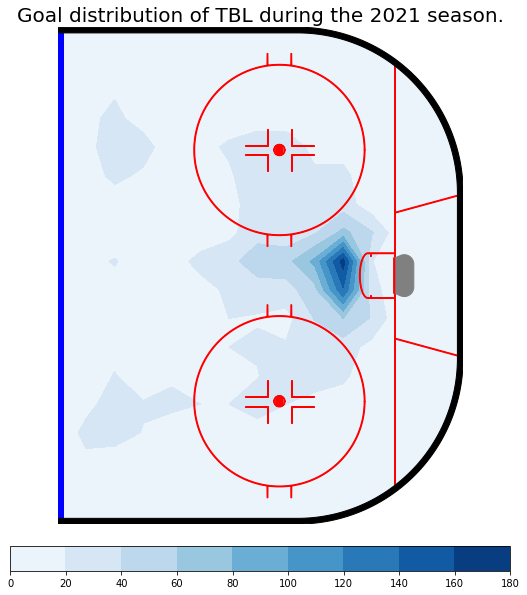

In [23]:
plotShots('TBL',2021)

In [25]:
shots['dist'] = np.sqrt((89-shots.x)**2 + (0-shots.y)**2)
print(shots)

        teamCode shotType   x   y  season       dist
0            TOR     MISS  41  13    2007  49.729267
1            TOR     MISS  66  -6    2007  23.769729
2            TOR     MISS  82  -9    2007  11.401754
3            TOR     SHOT  53  23    2007  42.720019
4            TOR     SHOT  84   3    2007   5.830952
...          ...      ...  ..  ..     ...        ...
1581492      ANA     MISS  55 -20    2021  39.446166
1581493      ANA     SHOT  81 -10    2021  12.806248
1581494      ANA     MISS  78   2    2021  11.180340
1581495      ANA     SHOT  60 -13    2021  31.780497
1581496      WSH     SHOT  87  14    2021  14.142136

[1581497 rows x 6 columns]


In [35]:
import seaborn as sns
def teamHeat(teamCode): 
    temp = shots
    df = (temp[(temp['teamCode'] == teamCode)])
    
    
    pivot_shots = df.pivot_table(index = 'season', columns = 'shotType', values= 'dist')
    sns.set(font_scale = 1.3)
    fig1, ax1 = plt.subplots(figsize=(20,14))
    ax1 = sns.heatmap(pivot_shots, cmap="YlGnBu",cbar_kws={'label': 'Shot Distance in Feet'})

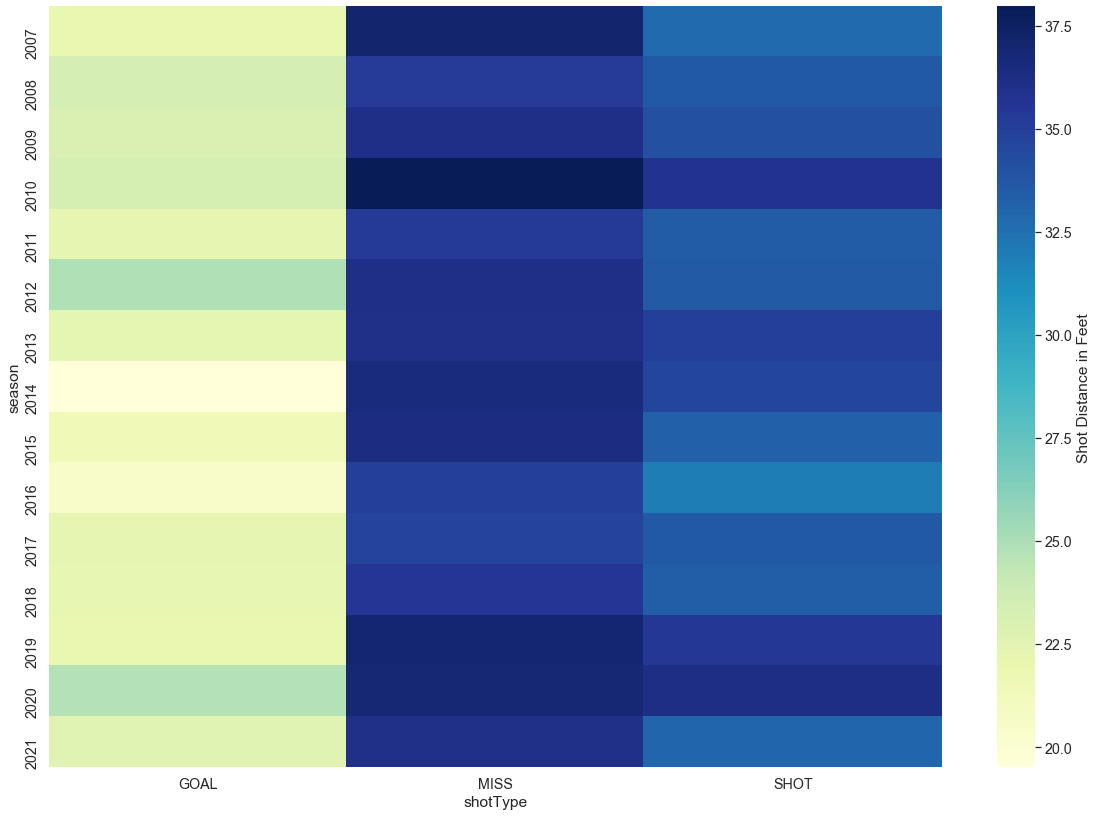

In [41]:
teamHeat('PIT')